<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

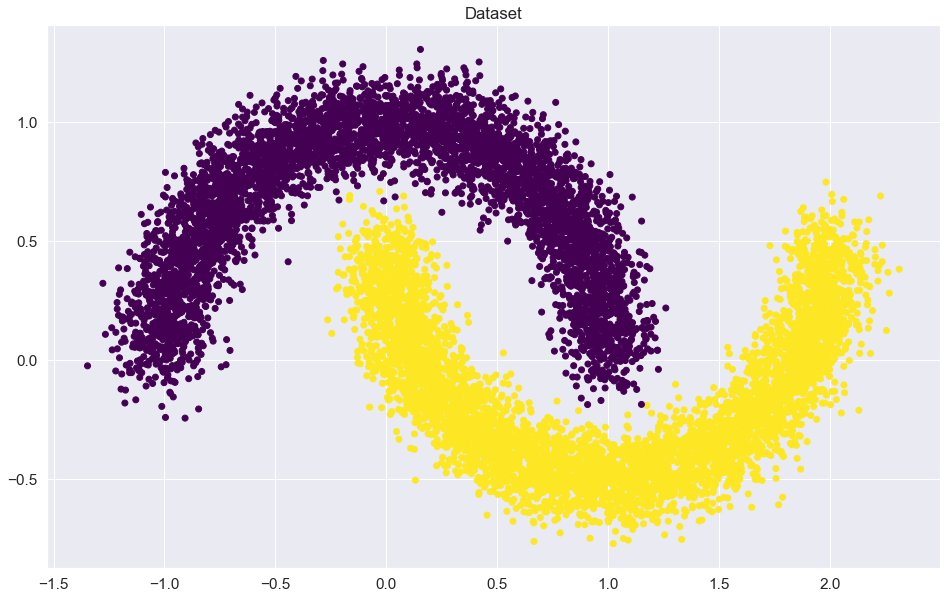

In [3]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [5]:
X_train_t =  torch.FloatTensor(X_train) # YOUR CODE GOES HERE
y_train_t =  torch.FloatTensor(y_train) # YOUR CODE GOES HERE
X_val_t =  torch.FloatTensor(X_val) # YOUR CODE GOES HERE
y_val_t =  torch.FloatTensor(y_val) # YOUR CODE GOES HERE

Создаем `Dataset` и `DataLoader`. 

In [6]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [7]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weights = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features)) # YOUR CODE GOES HERE
    def forward(self, x):
        x = x@self.weights # YOUR CODE GOES HERE
        if self.bias:
            x +=  self.bias_term # YOUR CODE GOES HERE
        return x

In [8]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели?

In [9]:
#YOUR CODE
list(linear_regression.parameters())

[Parameter containing:
 tensor([[0.9298],
         [0.0377]], requires_grad=True),
 Parameter containing:
 tensor([0.3830], requires_grad=True)]

**Ответ:** Всего обучаемых три параметра, включая смещение bias. 

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [10]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        #-------------------------------------------------------------------------------------
        outp =  linear_regression(X_batch) # YOUR CODE. Use linear_regression to get outputs
        outp = outp.view(-1)
        loss =  loss_function(outp, y_batch) # YOUR CODE. Compute loss
        #-------------------------------------------------------------------------------------
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        #-------------------------------------------------------------------------------------
        #probabilities = 1./(1 + (-outp).exp())     # YOUR CODE. Compute probabilities
        probabilities = torch.sigmoid(outp)
        #-------------------------------------------------------------------------------------
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if it % 500000 == 0:
            print(f"Iteration: {it + epoch*len(train_dataset)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch*len(train_dataset)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.6484375
Iteration: 7500
Batch accuracy: 0.75
Iteration: 15000
Batch accuracy: 0.7890625
Iteration: 22500
Batch accuracy: 0.78125
Iteration: 30000
Batch accuracy: 0.8046875
Iteration: 37500
Batch accuracy: 0.8046875
Iteration: 45000
Batch accuracy: 0.8046875
Iteration: 52500
Batch accuracy: 0.8125
Iteration: 60000
Batch accuracy: 0.8203125
Iteration: 67500
Batch accuracy: 0.8203125
Iteration: 75000
Batch accuracy: 0.8203125
Iteration: 82500
Batch accuracy: 0.8203125
Iteration: 90000
Batch accuracy: 0.8203125

Iteration: 90047.Convergence. Stopping iterations.


**Вопрос 2.**

Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** Понадобилось около 90000 итераций.

### Визуализируем результаты

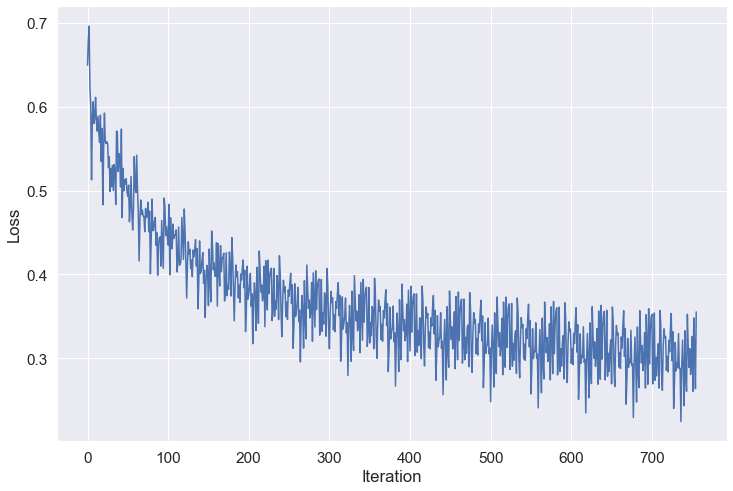

In [11]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

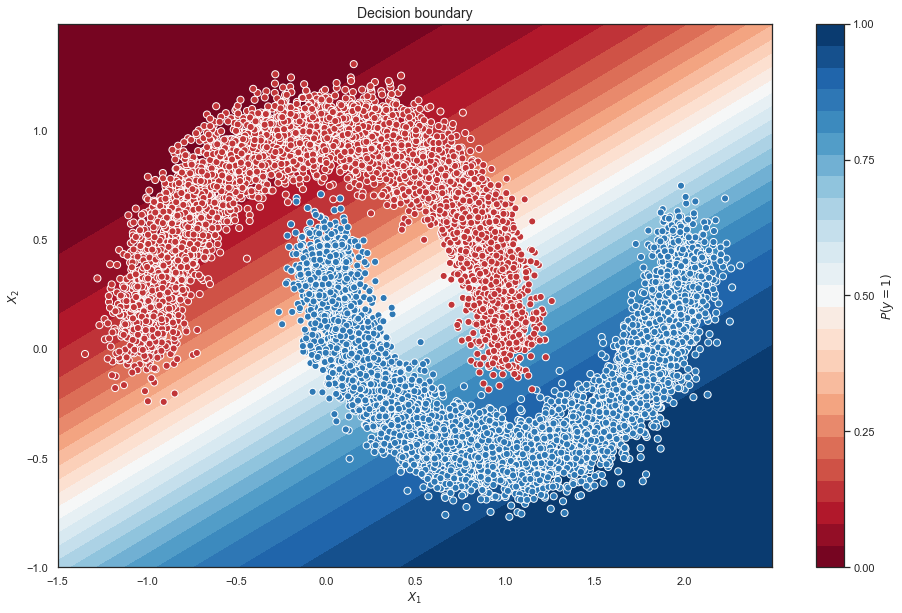

In [12]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [13]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        #YOUR CODE -------------------------------------------------
        outp =  model(x_batch) 
        outp = outp.view(-1)        
        probabilities = torch.sigmoid(outp) 
        preds = (probabilities > 0.5).type(torch.long)
        #YOUR CODE. Compute predictions ----------------------------
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [14]:
from sklearn.metrics import accuracy_score

# YOUR CODE. Compute total accuracy
val_predict = predict(val_dataloader, linear_regression)
total_accuracy = accuracy_score(y_val_t.numpy().flatten(), val_predict)
print("total_accuracy = {}".format(total_accuracy))

total_accuracy = 0.8616


###### **Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** После обучения на валидационной части датасета метрика **accuracy = 0.86.**

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [15]:
import os
from torchvision.datasets import MNIST

import torchvision.transforms as tfs
from torchsummary import summary

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

batch_size = 128

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True)
valid_dataloader = DataLoader(val_dataset, batch_size=batch_size, drop_last=True)

In [16]:
x_batch, y_batch = next(iter(train_dataloader))
x_batch.shape, y_batch.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [17]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [18]:
features = 784 #28*28
classes = 10

In [19]:
activation = nn.ELU()

model = nn.Sequential(
    nn.Flatten(),
    #YOUR CODE. Add layers to your sequential class
    nn.Linear(features,128),
    activation,
    nn.Linear(128, 128),
    activation,
    nn.Linear(128,classes)
)

In [20]:
summary(model, (features,), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [128, 784]               0
            Linear-2                 [128, 128]         100,480
               ELU-3                 [128, 128]               0
            Linear-4                 [128, 128]          16,512
               ELU-5                 [128, 128]               0
            Linear-6                  [128, 10]           1,290
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 1.28
Params size (MB): 0.45
Estimated Total Size (MB): 2.11
----------------------------------------------------------------


In [21]:
criterion = torch.nn.CrossEntropyLoss() #YOUR CODE. Select loss function
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ELU(alpha=1.0)
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): ELU(alpha=1.0)
  (5): Linear(in_features=128, out_features=10, bias=True)
)

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [23]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                # YOUR CODE GOES HERE---------------------------------------
                model.train()  
                optimizer.zero_grad() 
                outp = model(x_batch)
                #-----------------------------------------------------------   
            else:
                # YOUR CODE GOES HERE --------------------------------------
                model.eval()  
                with torch.no_grad():  
                    outp = model(x_batch) 
                #-----------------------------------------------------------
            preds = outp.argmax(-1)
            #correct = (preds==y_batch).type(torch.float32).sum() 
            correct =  (preds == y_batch).sum(dim=0)
            all =  y_batch.size(0)  
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                # YOUR CODE GOES HERE ---------------------------------
                loss.backward()  
                optimizer.step()     
                # YOUR CODE GOES HERE ---------------------------------
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.8814102564102564
Loader: valid. Accuracy: 0.9258814102564102
Epoch: 2
Loader: train. Accuracy: 0.9431089743589743
Loader: valid. Accuracy: 0.9541266025641025
Epoch: 3
Loader: train. Accuracy: 0.9597021901709402
Loader: valid. Accuracy: 0.9600360576923077
Epoch: 4
Loader: train. Accuracy: 0.96875
Loader: valid. Accuracy: 0.9627403846153846
Epoch: 5
Loader: train. Accuracy: 0.9743088942307693
Loader: valid. Accuracy: 0.965645032051282
Epoch: 6
Loader: train. Accuracy: 0.9782819177350427
Loader: valid. Accuracy: 0.9653445512820513
Epoch: 7
Loader: train. Accuracy: 0.9809194711538461
Loader: valid. Accuracy: 0.9684495192307693
Epoch: 8
Loader: train. Accuracy: 0.9833400106837606
Loader: valid. Accuracy: 0.9677483974358975
Epoch: 9
Loader: train. Accuracy: 0.9852263621794872
Loader: valid. Accuracy: 0.9705528846153846
Epoch: 10
Loader: train. Accuracy: 0.986328125
Loader: valid. Accuracy: 0.9703525641025641


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [24]:
# смотрим
elu_accuracy = accuracy["valid"]
print("elu_accuracy {}".format(max(elu_accuracy)))

elu_accuracy 0.9705528846153846


In [25]:
from tqdm.notebook import tqdm_notebook

In [31]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function 
# that returns a list of accuracies)

def test_activation_function(activation):
    #YOUR CODE
    
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(features,128),
        activation,
        nn.Linear(128, 128),
        activation,
        nn.Linear(128,classes)
        )
    
    criterion = torch.nn.CrossEntropyLoss() #Select loss function
    optimizer = torch.optim.Adam(model.parameters())
    model.to(device)
    
    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in tqdm_notebook(range(max_epochs)):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()  
                    optimizer.zero_grad() 
                    outp = model(x_batch)
                else:
                    model.eval()  
                    with torch.no_grad():  
                        outp = model(x_batch) 
                preds = outp.argmax(-1)
                #correct = (preds==y_batch).type(torch.float32).sum()
                correct =  (preds == y_batch).sum(dim=0)
                all =  y_batch.size(0)  
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward()  
                    optimizer.step()     
            accuracy[k].append(epoch_correct/epoch_all)
    return accuracy["valid"]     

Проверяем работу функции

In [32]:
%%time
print('elu_accuracy')
elu_accuracy = test_activation_function(nn.ELU())
print("elu_accuracy {}".format(max(elu_accuracy)))

elu_accuracy


  0%|          | 0/10 [00:00<?, ?it/s]

elu_accuracy 0.9681490384615384
Wall time: 3min 10s


In [37]:
%%time
plain_accuracy = test_activation_function(Identical())
print("plain_accuracy {}".format(max(plain_accuracy)))

relu_accuracy = test_activation_function(nn.ReLU()) #YOUR CODE
print("relu_accuracy {}".format(max(relu_accuracy)))

leaky_relu_accuracy = test_activation_function(nn.LeakyReLU()) #YOUR CODE
print("leaky_relu_accuracy {}".format(max(leaky_relu_accuracy)))

  0%|          | 0/10 [00:00<?, ?it/s]

plain_accuracy 0.9037459935897436


  0%|          | 0/10 [00:00<?, ?it/s]

relu_accuracy 0.9711538461538461


  0%|          | 0/10 [00:00<?, ?it/s]

leaky_relu_accuracy 0.9709535256410257
Wall time: 8min 49s


### Accuracy
Построим график accuracy/epoch для каждой функции активации.

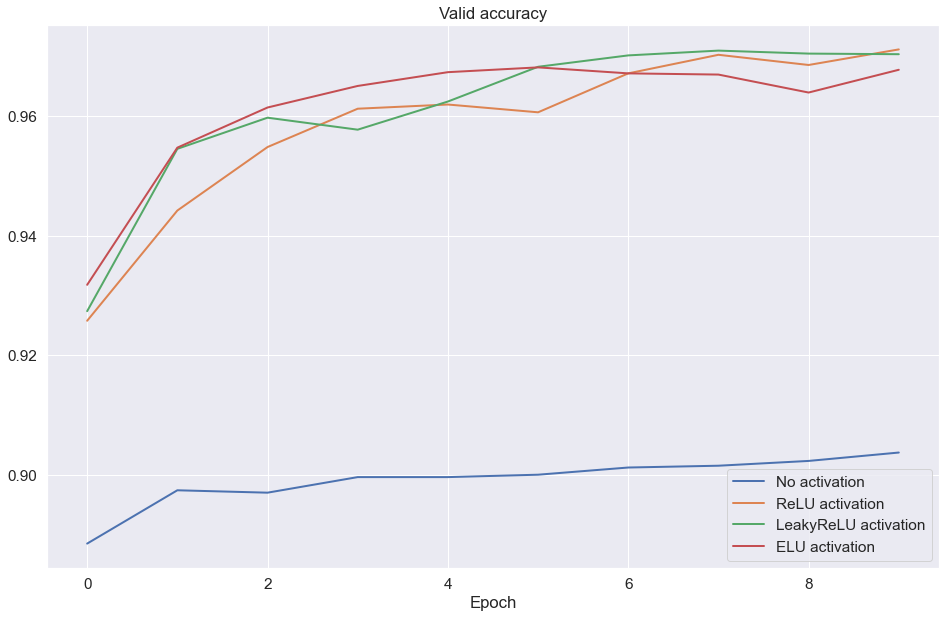

In [39]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

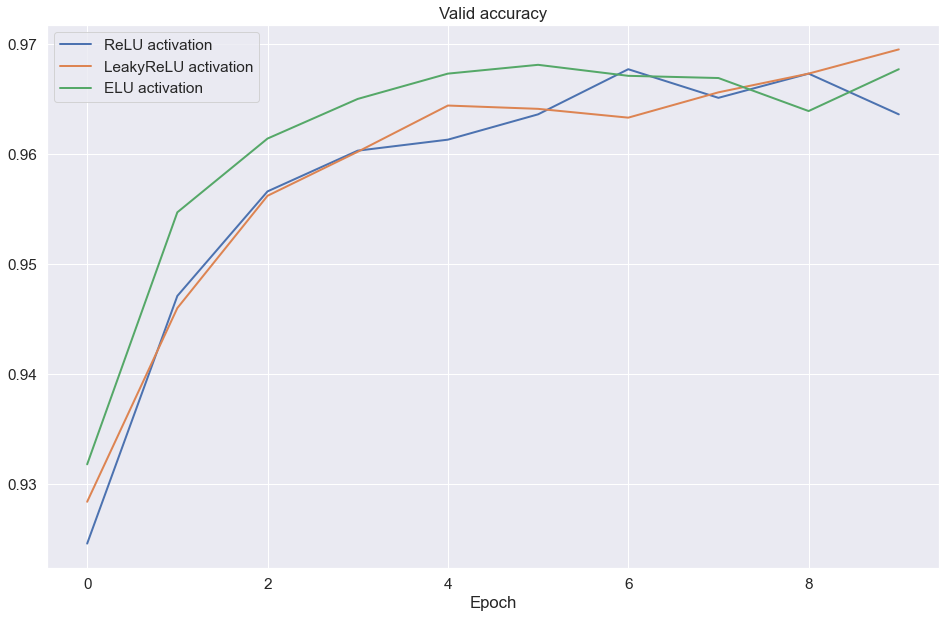

In [35]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [40]:
print("plain_accuracy {}".format(max(plain_accuracy)))
print("relu_accuracy {}".format(max(relu_accuracy)))
print("leaky_relu_accuracy {}".format(max(leaky_relu_accuracy)))
print("elu_accuracy {}".format(max(elu_accuracy)))

plain_accuracy 0.9037459935897436
relu_accuracy 0.9711538461538461
leaky_relu_accuracy 0.9709535256410257
elu_accuracy 0.9681490384615384


**Вопрос 4** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** Наивысший `accuracy` к концу обучения на 10 эпохах показала активация **leaky_relu**. Возможно увеличение количества эпох дало бы другой результат, так как разница между ReLU, LeakyReLU и ELU наблюдается в третьем знаке после запятой. Также видно нестабильное поведение графиков в виде осцилляций с выходом на плато.

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [ ]:
#!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

In [ ]:
#!pip3 install opencv-python

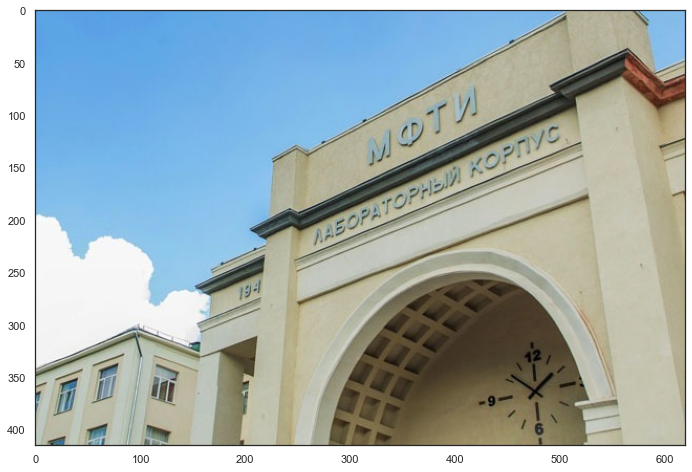

In [41]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [42]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


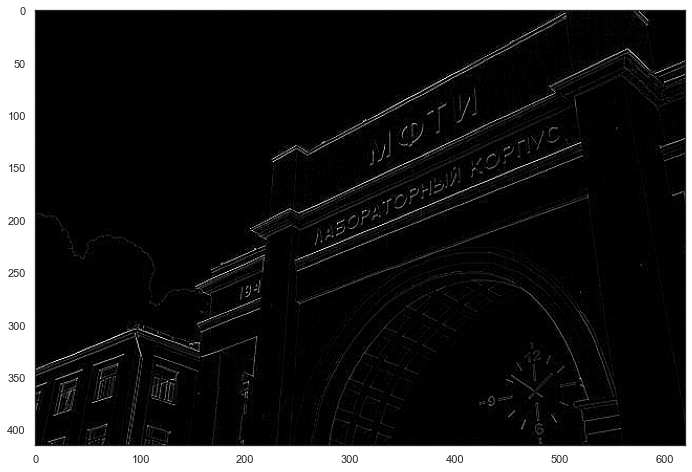

In [43]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие - E

2) Увеличение резкости - Д 

3) Тождественное преобразование - А

4) Выделение вертикальных границ - Б

5) Выделение горизонтальных границ - В

6) Выделение границ - Г

**Ответ:** 1-E, 2-Д, 3-A, 4-Б, 5-В, 6-Г (A3, Б4, В5, Г6, Д2, Е1)

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [44]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        #YOUR CODE -----------------------------------------------------------------
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2) #, stride=2) по умолчанию stride = kernel_size
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3) 
        self.pool2 = nn.MaxPool2d(kernel_size=2) #, stride=2)
        self.flatt = nn.Flatten()
        self.fc1 = nn.Linear(400,120)   # или -> LazyLinear(120)
        self.fc2 = nn.Linear(120, 84) 
        self.fc3 = nn.Linear(84,10) 
        #YOUR CODE -----------------------------------------------------------------

    def forward(self, x):
        #YOUR CODE -----------------------------------------------------------------
        x = self.pool1(F.relu(self.conv1(x))) #YOUR CODE. Apply layers created in __init__. 
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.flatt(x)
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x)) 
        x = self.fc3(x) 
        #YOUR CODE -----------------------------------------------------------------
        return x

In [45]:
# смотрим
summary(LeNet(), (1, 28, 28), batch_size=batch_size)
LeNet().to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [128, 6, 26, 26]              60
         MaxPool2d-2           [128, 6, 13, 13]               0
            Conv2d-3          [128, 16, 11, 11]             880
         MaxPool2d-4            [128, 16, 5, 5]               0
           Flatten-5                 [128, 400]               0
            Linear-6                 [128, 120]          48,120
            Linear-7                  [128, 84]          10,164
            Linear-8                  [128, 10]             850
Total params: 60,074
Trainable params: 60,074
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 7.83
Params size (MB): 0.23
Estimated Total Size (MB): 8.44
----------------------------------------------------------------


LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatt): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [46]:
#next(iter(train_dataloader))[0].shape

In [47]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [48]:
    model.to(device)
    
    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in tqdm_notebook(range(max_epochs)):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()  
                    optimizer.zero_grad() 
                    outp = model(x_batch)
                else:
                    model.eval()  
                    with torch.no_grad():  
                        outp = model(x_batch) 
                preds = outp.argmax(-1)
                #correct = (preds==y_batch).type(torch.float32).sum()
                correct =  (preds == y_batch).sum(dim=0)
                all =  y_batch.size(0)  
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward()  
                    optimizer.step()     
            accuracy[k].append(epoch_correct/epoch_all)
 

  0%|          | 0/10 [00:00<?, ?it/s]

In [51]:
lenet_accuracy = accuracy["valid"]
print("lenet_accuracy {}".format(max(lenet_accuracy)))

lenet_accuracy 0.9858774038461539


Сравним с предыдущем пунктом

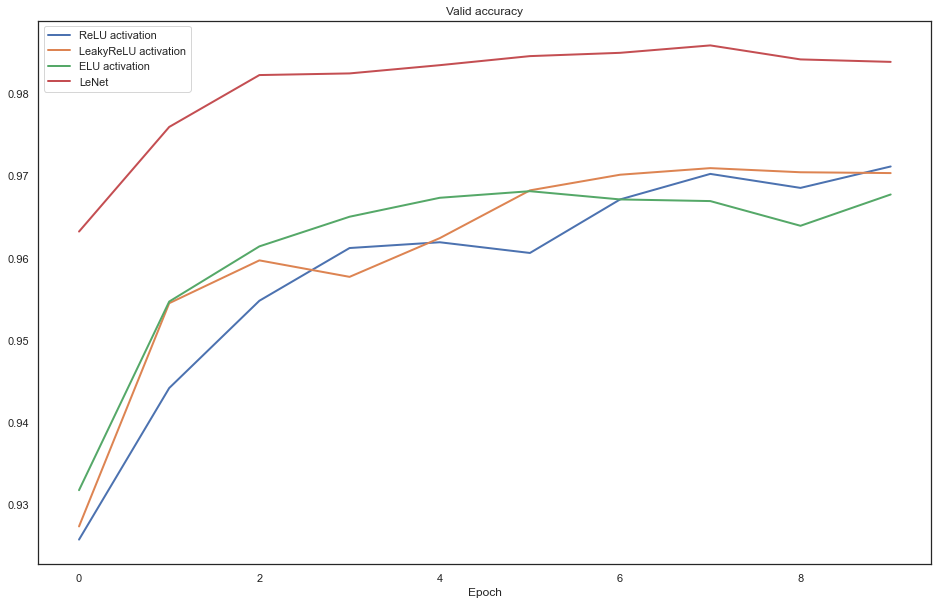

In [50]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** ` LeNet Accuracy = 0.99 `